# Deploying stocks model serving

Steps
* [Creating serving graph](#Creating-serving-graph)
* [Testing locally](#Testing-locally)
* [Deploying the serving graph](#Deploying-the-serving-graph)

In [1]:
import mlrun
import os

project = mlrun.get_or_create_project('stocks',user_project=True,context='./')

> 2022-11-08 11:42:14,111 [info] loaded project stocks from MLRun DB


## Creating serving graph

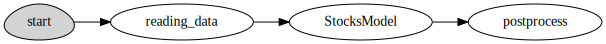

In [2]:
fn = mlrun.code_to_function('serving-stocks', kind='serving',image='mlrun/ml-models', filename='src/serving_stocks.py').apply(mlrun.auto_mount())

graph = fn.set_topology("flow", engine="async")
# Build the serving graph:
graph.to(handler='preprocess', name='reading_data')\
     .to(class_name="StocksModel", model_name='stocks_model', model_path=project.get_artifact_uri('stocks_model'))\
     .to(handler='postprocess',name='postprocess').respond()

fn.set_tracking()

fn.plot(rankdir="LR")

## Testing locally

In [3]:
server = fn.to_mock_server()

> 2022-11-08 11:42:28,581 [info] downloading v3io:///projects/stocks-dani/artifacts/train-stocks-model-handler/0/stocks_model_custom_objects_map.json.json to local temp file
> 2022-11-08 11:42:28,596 [info] downloading v3io:///projects/stocks-dani/artifacts/train-stocks-model-handler/0/stocks_model_custom_objects.zip.zip to local temp file
> 2022-11-08 11:42:36,840 [info] model StocksModel was loaded


In [4]:
import pandas as pd
response = server.test(body={"vector_name": 'stocks',
                             "start_time" : 6, # days to go back
                             "end_time"   : 0,
                             "seq_size"   : 5})

pd.DataFrame(data=response[0], columns=response[1]).head()

writing prediction to kv at projects/stocks-dani/artifacts/stocks_prediction ...


,prediction,datetime,tickers,true
0,15.303180,2022-11-07 16:00:00,AAL,14.319996
1,145.407950,2022-11-07 16:00:00,AAPL,138.919998
2,140.045847,2022-11-07 16:00:00,A,138.029999
3,98.304830,2022-11-07 16:00:00,ABT,99.500001
4,183.779591,2022-11-07 16:00:00,AAP,183.089997


## Deploying the serving graph

In [5]:
address = fn.deploy()

> 2022-11-08 11:42:39,036 [info] Starting remote function deploy
2022-11-08 11:42:41  (info) Deploying function
2022-11-08 11:42:41  (info) Building
2022-11-08 11:42:41  (info) Staging files and preparing base images
2022-11-08 11:42:41  (info) Building processor image
2022-11-08 11:45:37  (info) Build complete
2022-11-08 11:46:33  (info) Function deploy complete
> 2022-11-08 11:46:34,253 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-serving-stocks.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-serving-stocks-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/']}


In [6]:
project.set_function(fn,name='serving-stocks')
project.save()

In [16]:
import json
response = fn.invoke(path=address,
                     body={"vector_name": 'stocks',
                           "start_time" : 6,
                           "end_time"   : 0,
                           "seq_size"   : 5})

pd.DataFrame(data=response[0], columns=response[1])

> 2022-11-08 12:06:30,245 [info] invoking function: {'method': 'POST', 'path': 'http://stocks-dani-serving-stocks-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/'}


,prediction,datetime,tickers,true
0,13.090603,2022-11-07 16:00:00,AAL,14.319996
1,137.945280,2022-11-07 16:00:00,AAPL,138.919998
2,138.133004,2022-11-07 16:00:00,A,138.029999
3,98.775466,2022-11-07 16:00:00,ABT,99.500001
4,183.601304,2022-11-07 16:00:00,AAP,183.089997
5,164.494394,2022-11-07 16:00:00,ABC,162.009995
6,58.154310,2022-11-07 16:00:00,ACGL,58.009995
7,148.412744,2022-11-07 16:00:00,ABBV,148.100006
8,372.404377,2022-11-07 16:00:00,ABMD,373.290003
9,268.222517,2022-11-07 16:00:00,ACN,269.070010


## Scheduling the serving function

In [17]:
body = {"vector_name": 'stocks',
        "start_time" : 59,
        "end_time"   : 0,
        "seq_size"   : 5}

# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='prediction-kv',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':address, 'body': body}, schedule='*/10 * * * *')

> 2022-11-08 12:06:50,780 [info] starting run prediction-kv-ingestion_service_invoker uid=8f635554f88a44309e84a4c3649e8273 DB=http://mlrun-api:8080
> 2022-11-08 12:06:51,020 [info] task scheduled, {'schedule': '*/10 * * * *', 'project': 'stocks-dani', 'name': 'prediction-kv-ingestion_service_invoker'}
